In [165]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
import datetime
#import mylib
#sns.set_style('whitegrid')
from scipy import stats
import statsmodels.formula.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


In [2]:
df = pd.read_csv('pae_survey.csv')

# Functions

In [3]:
# SEP utils file
def missing_heat_map(DataFrame):
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 6))
    sns.heatmap(DataFrame.isnull(), yticklabels=False, ax = ax, cbar=False,\
                cmap='viridis')
    ax.set_title('dataset')
    plt.show()
        
    # Calculate the missing values to get a percentage 

    for i in DataFrame:
        print(i,': %',int((DataFrame[i].isnull().sum()/len(DataFrame[i]))*100),\
            'With {} missing values'.format((DataFrame[i].isnull().sum())))

In [4]:
def pie_chart(chart_name,name,column,varibles):
    pie, ax = plt.subplots(figsize=[10,6])
    labels = column.value_counts().keys()
    plt.pie(x=column.value_counts().values, autopct="%.1f%%", explode=[0.05]*int(varibles), labels=labels, pctdistance=0.5)
    plt.title("{}".format(chart_name), fontsize=14);
    pie.savefig("pics/{}.png".format(name))

In [5]:
def plot_corr(df):

    """
    This function will plot the correlation
    Arguments:
    df: takes a data frame 
 
    Returns:
    a plot of the correlations in the data frame
    """

    plt.figure(figsize=(20,10))
    corr=df.corr()
    sns.set(font_scale=2.5)
    sns.heatmap(corr,annot=True, vmin=0, vmax=1, cmap = 'gist_heat_r')



In [6]:
def magnify_corr(dataframe):

    """
    This function will plot the correlation using an interactive plot
    Arguments:
    dataframe: takes a dataframe 
 
    Returns:
    a plot of the correlations in the data frame
    """
    
    cmap=sns.diverging_palette(5, 250, as_cmap=True)
    corr = dataframe.corr()
    
    a = [dict(selector="th",props=[("font-size","7pt")]),
     dict(selector="td",props=[('padding',"0em 0em")]),
     dict(selector="th:hover",props=[("font-size","12pt")]),
     dict(selector="tr:hover td:hover",props=[('max-width','200px'),('font-size','12pt')])]
    
    
    return corr.style.background_gradient(cmap, axis=1)\
        .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
        .set_caption("Hover to magify")\
        .set_precision(2)\
        .set_table_styles(a)



In [7]:
def top_corr_features(target,number,dataframe):
    """
    This function will give you the required number of highest correlated features to a target 
    Arguments:
    target: column name in string format of the targeted column
    number: The number of highest correlated features required
    data frame: the data frame name without parenthesis 

    returns: A list of the highest correlated features with the target (will also print the list)
    """
    best_feature_corr=dataframe.corr()[str(target)].sort_values(ascending=False)\
        .index[0:int(number)].tolist()
    print('list of {} best positive features based on pairwise correlation:\n'\
        .format(number),best_feature_corr)
    return best_feature_corr

# Data preparation and Understanding

In [8]:
df.head()

,Timestamp,1) What is your gender?,2) What is your marital status?,3) In which region are you located?,4) Did you get your bachelor degree in Saudi or Abroad?,"5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A.",6) Have you ever studied in a mixed-sex university?,"7) After you spend a long day, how do you gain energy?",8) The people who know you best are more likely to describe you as someone who is:,9) Do you think that household chores should be equally divided between men and women? [Choose:],10) Do you prefer working in a single-sex work environment or mixed-sex work environment?,11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender? [Choose:],"12) If someone from the opposite gender has the information you need at work, how likely will you ask for the information? [Choose:]",13) How likely are you willing to work on a project with someone from the opposite gender? [Choose:],"14) If you studied abroad, can you identify any event that influenced your views about gender?",15) Are you with or against mixed-sex universities in Saudi?,16) What do you think about having mixed-sex universities in Saudi? Please list three reasons why or why not.
0,2020/12/02 1:19:18 PM GMT+3,Female,Single,Eastern,Abroad,NaN,"Yes, undergrad",Inner reflection and solitude,Quiet and reflective,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,Against mixed-sex universities,NaN
1,2020/12/02 1:21:06 PM GMT+3,Male,Single,Center,Saudi,Abroad,"Yes, grad",Going out with friends,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,NaN,Against mixed-sex universities,"Against it, privacy, competitiveness, security"
2,2020/12/02 1:29:40 PM GMT+3,Male,Single,Center,Saudi,NaN,"No, neither",Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,"Open mind, ice breaks and better environment"
3,2020/12/02 1:31:00 PM GMT+3,Female,Single,Center,Saudi,NaN,"No, neither",Inner reflection and solitude,Outgoing and talkative,3: Agree,Single-sex work environment,3: Comfortable,4: Highly likely,3: Likely,NaN,Against mixed-sex universities,1- it’s could be a problem in our society’s cu...
4,2020/12/02 1:36:05 PM GMT+3,Female,Single,Eastern,Saudi,NaN,"No, neither",Going out with friends,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,3: Comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,I agree.\n1. Preparing students for mixed-sex ...


In [9]:
df.columns

Index(['Timestamp', '1) What is your gender? ',
       '2) What is your marital status? ',
       '3) In which region are you located? ',
       '4) Did you get your bachelor degree in Saudi or Abroad?',
       '5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A.',
       '6) Have you ever studied in a mixed-sex university? ',
       '7) After you spend a long day, how do you gain energy? ',
       '8) The people who know you best are more likely to describe you as someone who is:',
       '9) Do you think that household chores should be equally divided between men and women? [Choose:]',
       '10) Do you prefer working in a single-sex work environment or mixed-sex work environment? ',
       '11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender?  [Choose:]',
       '12) If someone from the opposite gender has the information you need at work, how likely will you as

In [10]:
df.rename(columns={'1) What is your gender? ':'gender',
                   '2) What is your marital status? ':'marital_status',
                   '3) In which region are you located? ':'region',
                   '4) Did you get your bachelor degree in Saudi or Abroad?':'bachelor_loc',
                   "5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A.":"masters_loc",
                   '6) Have you ever studied in a mixed-sex university? ':'mixed_sex',
                   '7) After you spend a long day, how do you gain energy? ':'introversion_personal',
                   '8) The people who know you best are more likely to describe you as someone who is:':'introversion_public',
                   '9) Do you think that household chores should be equally divided between men and women? [Choose:]':'household_chores',
                   '10) Do you prefer working in a single-sex work environment or mixed-sex work environment? ':'single_vs_mixed_working_env',
                   '11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender?  [Choose:]':'comfort_with_other_gender',
                   '12) If someone from the opposite gender has the information you need at work, how likely will you ask for the information?  [Choose:]':'comfort_with_help_from_other_gender',
                   '13) How likely are you willing to work on a project with someone from the opposite gender? [Choose:]':'project_with_other_gender',
                   '14) If you studied abroad, can you identify any event that influenced your views about gender?':'events_that_influnced_gender_views',
                   '15) Are you with or against mixed-sex universities in Saudi? ':'with_or_aginst_mixed_sex_universities',
                   '16) What do you think about having mixed-sex universities in Saudi? Please list three reasons why or why not.':'opinion_mixed_sex_universites',
                   'Timestamp':'timestamp'
    
                  },inplace=True)

In [11]:
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites'],
      dtype='object')

In [12]:
df['comfort_with_help_from_other_gender'].value_counts()

4: Highly likely    78
3: Likely           22
2: Unlikely          4
Name: comfort_with_help_from_other_gender, dtype: int64

In [13]:
df['single_vs_mixed_working_env'].value_counts()

Mixed-sex work environment     81
Single-sex work environment    23
Name: single_vs_mixed_working_env, dtype: int64

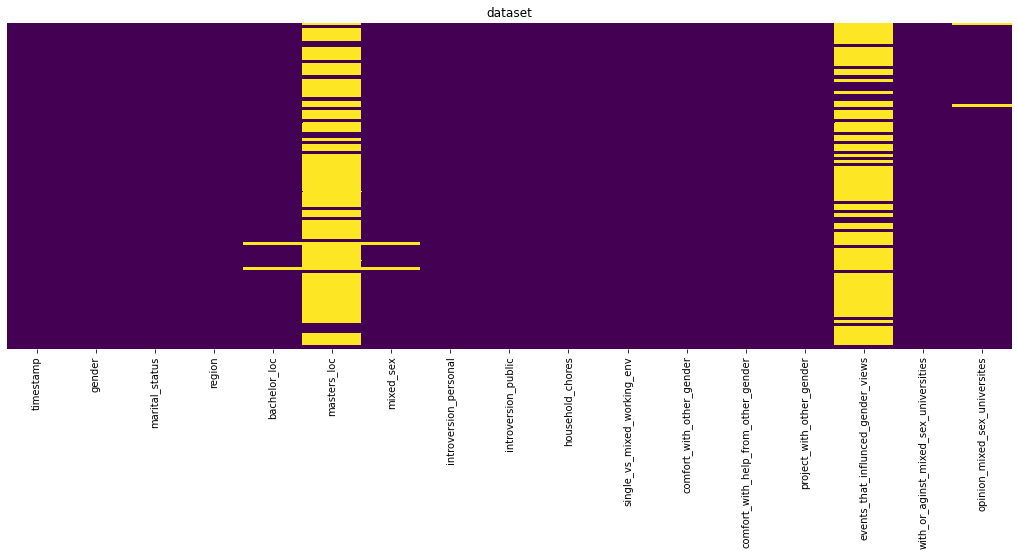

timestamp : % 0 With 0 missing values
gender : % 0 With 0 missing values
marital_status : % 0 With 0 missing values
region : % 0 With 0 missing values
bachelor_loc : % 1 With 2 missing values
masters_loc : % 80 With 84 missing values
mixed_sex : % 1 With 2 missing values
introversion_personal : % 0 With 0 missing values
introversion_public : % 0 With 0 missing values
household_chores : % 0 With 0 missing values
single_vs_mixed_working_env : % 0 With 0 missing values
comfort_with_other_gender : % 0 With 0 missing values
comfort_with_help_from_other_gender : % 0 With 0 missing values
project_with_other_gender : % 0 With 0 missing values
events_that_influnced_gender_views : % 75 With 79 missing values
with_or_aginst_mixed_sex_universities : % 0 With 0 missing values
opinion_mixed_sex_universites : % 1 With 2 missing values


In [14]:
missing_heat_map(df)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   timestamp                              104 non-null    object
 1   gender                                 104 non-null    object
 2   marital_status                         104 non-null    object
 3   region                                 104 non-null    object
 4   bachelor_loc                           102 non-null    object
 5   masters_loc                            20 non-null     object
 6   mixed_sex                              102 non-null    object
 7   introversion_personal                  104 non-null    object
 8   introversion_public                    104 non-null    object
 9   household_chores                       104 non-null    object
 10  single_vs_mixed_working_env            104 non-null    object
 11  comfort_with_other_

## Timestamp

In [16]:
#fixed to datetime format
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x.strip('+3'), '%Y/%m/%d %H:%M:%S %p %Z'))

In [17]:
df['timestamp']

0     2020-12-02 01:19:18
1     2020-12-02 01:21:06
2     2020-12-02 01:29:40
3     2020-12-02 01:31:00
4     2020-12-02 01:36:05
              ...        
99    2020-12-14 05:23:38
100   2020-12-14 05:41:25
101   2020-12-14 07:21:38
102   2020-12-15 12:18:42
103   2020-12-15 12:20:47
Name: timestamp, Length: 104, dtype: datetime64[ns]

## gender
**1) What is your gender?**

In [18]:
df['gender'].value_counts()

Male      65
Female    39
Name: gender, dtype: int64

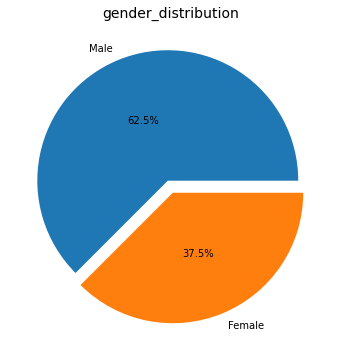

In [19]:
pie_chart('gender_distribution','gender_pie',df['gender'],2)

<AxesSubplot:xlabel='gender', ylabel='Count'>

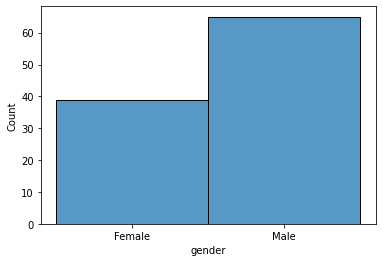

In [20]:
sns.histplot(df['gender'])

## marital_status
**2) What is your marital status?** 

In [21]:
df['marital_status'].value_counts()

Single     98
Married     6
Name: marital_status, dtype: int64

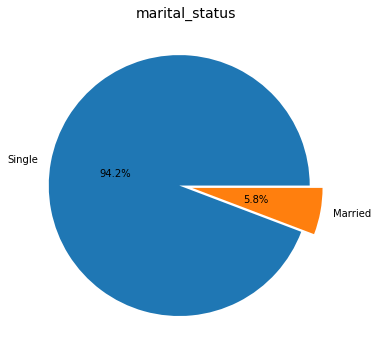

In [22]:
pie_chart('marital_status','marital_status_pie',df['marital_status'],2)

<AxesSubplot:xlabel='marital_status', ylabel='Count'>

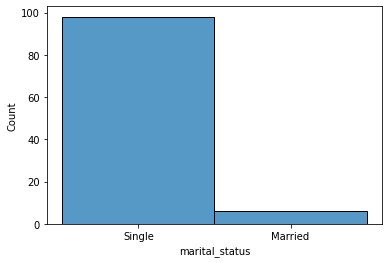

In [23]:
sns.histplot(df['marital_status'])

## region
**3) In which region are you located?**

In [24]:
df['region'].value_counts()

Center     62
Western    26
Eastern    15
Nothern     1
Name: region, dtype: int64

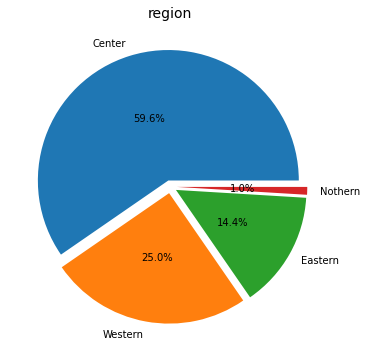

In [25]:
pie_chart('region','region_pie',df['region'],4)

<AxesSubplot:xlabel='region', ylabel='Count'>

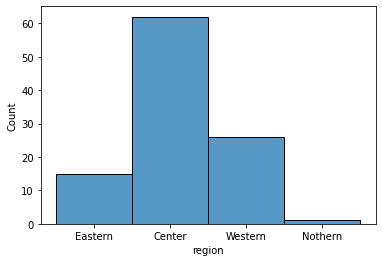

In [26]:
sns.histplot(df['region'])

## bachelor_loc
**4) Did you get your bachelor degree in Saudi or Abroad?**

In [27]:
df['bachelor_loc'].isnull().sum()

2

In [28]:
df[df['bachelor_loc'].isnull()==True]

,timestamp,gender,marital_status,region,bachelor_loc,masters_loc,mixed_sex,introversion_personal,introversion_public,household_chores,single_vs_mixed_working_env,comfort_with_other_gender,comfort_with_help_from_other_gender,project_with_other_gender,events_that_influnced_gender_views,with_or_aginst_mixed_sex_universities,opinion_mixed_sex_universites
70,2020-12-06 05:02:25,Male,Single,Center,NaN,NaN,NaN,Inner reflection and solitude,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,NaN,Against mixed-sex universities,"Privacy, Competitiveness, Security"
78,2020-12-12 02:16:21,Male,Single,Center,NaN,NaN,NaN,Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,"Open mind, ice breaks and better environment"


In [29]:
df['bachelor_loc'].value_counts()

Saudi     67
Abroad    35
Name: bachelor_loc, dtype: int64

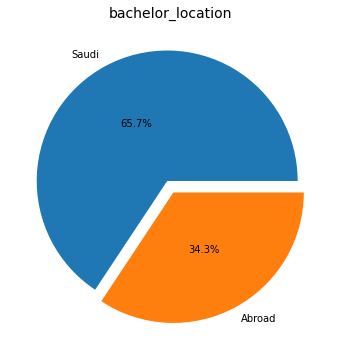

In [30]:
pie_chart('bachelor_location','bachelor_location_pie',df['bachelor_loc'],2)

In [31]:
df['bachelor_loc'].fillna('n/a',inplace=True)

<AxesSubplot:xlabel='bachelor_loc', ylabel='Count'>

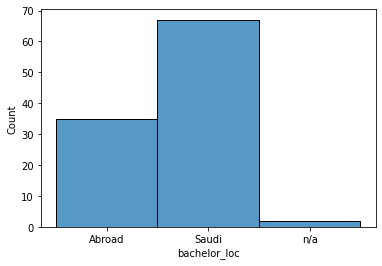

In [32]:
sns.histplot(df['bachelor_loc'])

## Masters_loc
**5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A**

In [33]:
df['masters_loc'].isnull().sum()

84

In [34]:
df['masters_loc'].value_counts()

Abroad    15
Saudi      5
Name: masters_loc, dtype: int64

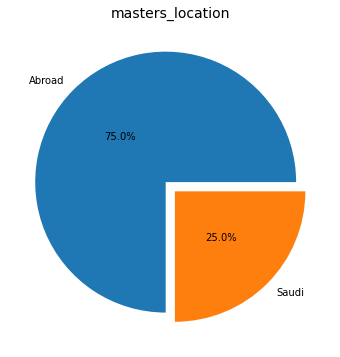

In [36]:
pie_chart('masters_location','masters_location_pie',df['masters_loc'],2)

In [37]:
df['masters_loc'].fillna('n/a',inplace=True)

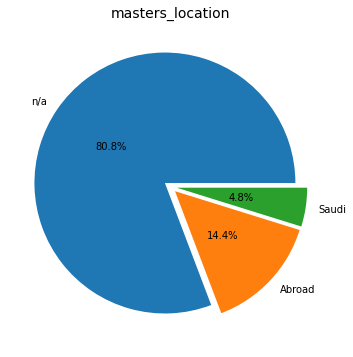

In [38]:
pie_chart('masters_location','masters_location_pie',df['masters_loc'],3)

<AxesSubplot:xlabel='masters_loc', ylabel='Count'>

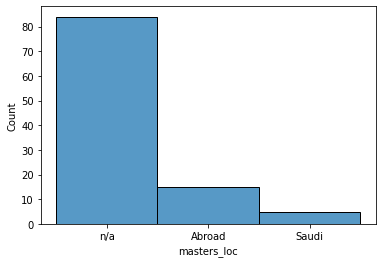

In [41]:
sns.histplot(df['masters_loc'])

## mixed_sex
**6) Have you ever studied in a mixed-sex university?**

In [42]:
df['mixed_sex'].isnull().sum()

2

In [43]:
df[df['mixed_sex'].isnull()==True]


,timestamp,gender,marital_status,region,bachelor_loc,masters_loc,mixed_sex,introversion_personal,introversion_public,household_chores,single_vs_mixed_working_env,comfort_with_other_gender,comfort_with_help_from_other_gender,project_with_other_gender,events_that_influnced_gender_views,with_or_aginst_mixed_sex_universities,opinion_mixed_sex_universites
70,2020-12-06 05:02:25,Male,Single,Center,n/a,n/a,NaN,Inner reflection and solitude,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,NaN,Against mixed-sex universities,"Privacy, Competitiveness, Security"
78,2020-12-12 02:16:21,Male,Single,Center,n/a,n/a,NaN,Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,"Open mind, ice breaks and better environment"


In [44]:
df['mixed_sex'].value_counts()

Yes, undergrad    52
No, neither       31
Yes, grad         10
Yes, both          9
Name: mixed_sex, dtype: int64

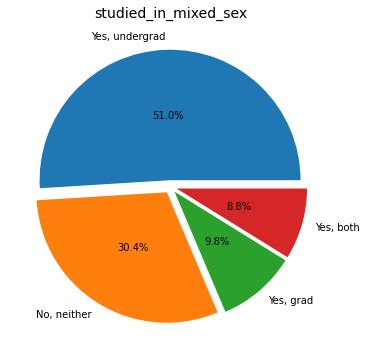

In [45]:
pie_chart('studied_in_mixed_sex','mixedsex_experince_pie',df['mixed_sex'],4)

In [46]:
df['mixed_sex'].fillna('n/a',inplace=True)

<AxesSubplot:xlabel='mixed_sex', ylabel='Count'>

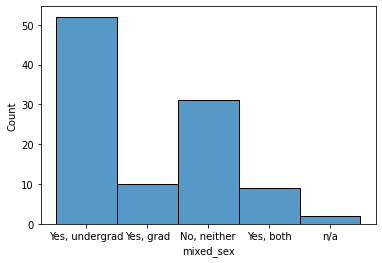

In [47]:
sns.histplot(df['mixed_sex'])

## introversion_personal
**7) After you spend a long day, how do you gain energy?**

In [48]:
df['introversion_personal'].value_counts()

Inner reflection and solitude    66
Going out with friends           38
Name: introversion_personal, dtype: int64

<AxesSubplot:xlabel='introversion_personal', ylabel='Count'>

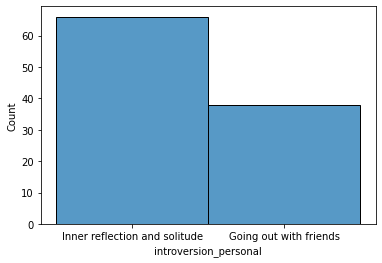

In [49]:
sns.histplot(df['introversion_personal'])

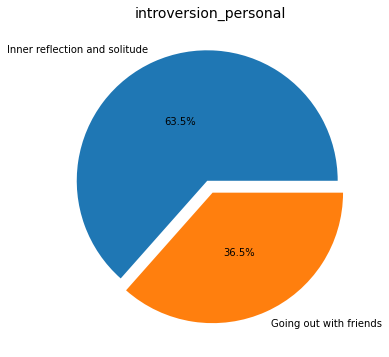

In [50]:
pie_chart('introversion_personal','introversion_personal_pie',df['introversion_personal'],2)

## introversion_public
**8) The people who know you best are more likely to describe you as someone who is:**

In [51]:
df['introversion_public'].value_counts()

Outgoing and talkative    62
Quiet and reflective      42
Name: introversion_public, dtype: int64

<AxesSubplot:xlabel='introversion_public', ylabel='Count'>

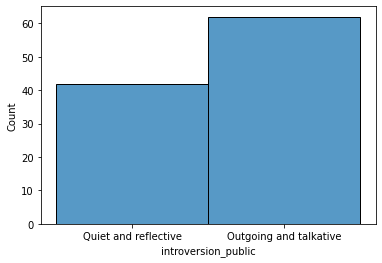

In [52]:
sns.histplot(df['introversion_public'])

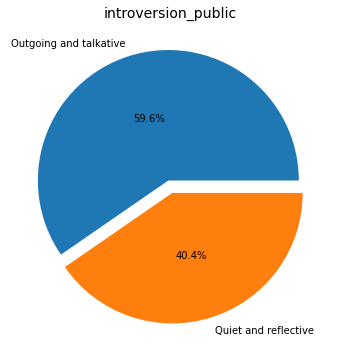

In [53]:
pie_chart('introversion_public','introversion_public_pie',df['introversion_public'],2)

## household_chores
**9) Do you think that household chores should be equally divided between men and women?**

In [54]:
df['household_chores'].value_counts()

3: Agree                48
4: Strongly agree       35
2: Disagree             18
1: Strongly disagree     3
Name: household_chores, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

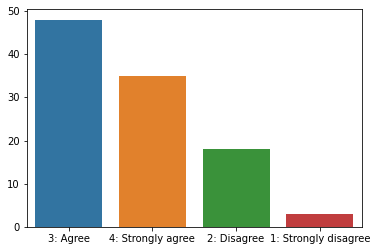

In [55]:
sns.barplot(df['household_chores'].value_counts().keys(),df['household_chores'].value_counts().values)

## single_vs_mixed_working_env
**10) Do you prefer working in a single-sex work environment or mixed-sex work environment?**

In [56]:
df['single_vs_mixed_working_env'].value_counts()

Mixed-sex work environment     81
Single-sex work environment    23
Name: single_vs_mixed_working_env, dtype: int64

<AxesSubplot:xlabel='single_vs_mixed_working_env', ylabel='Count'>

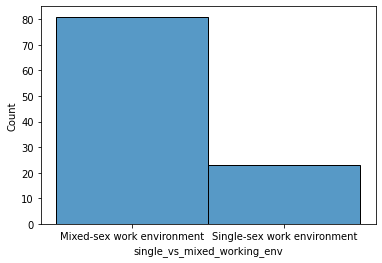

In [57]:
sns.histplot(df['single_vs_mixed_working_env'])

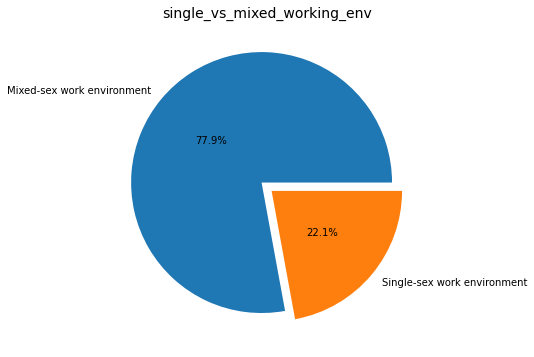

In [58]:
pie_chart('single_vs_mixed_working_env','single_vs_mixed_working_env_pie',df['single_vs_mixed_working_env'],2)

## comfort_with_other_gender
**11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender?**

In [59]:
df['comfort_with_other_gender'].value_counts()

4: Very comfortable      45
3: Comfortable           45
2: Uncomfortable         10
1: Very uncomfortable     4
Name: comfort_with_other_gender, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

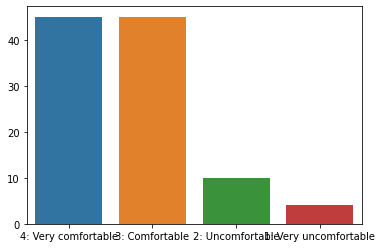

In [60]:
sns.barplot(df['comfort_with_other_gender'].value_counts().keys(),df['comfort_with_other_gender'].value_counts().values)

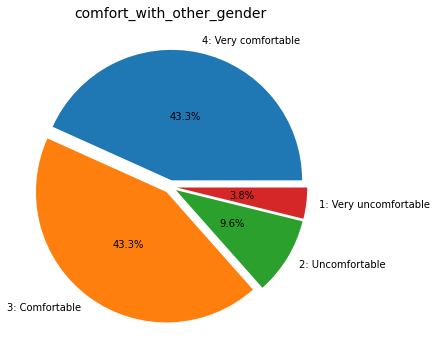

In [61]:
pie_chart('comfort_with_other_gender','comfort_with_other_gender_pie',df['comfort_with_other_gender'],4)

## comfort_with_help_from_other_gender
**12) If someone from the opposite gender has the information you need at work, how likely will you ask for the information?**

In [62]:
df['comfort_with_help_from_other_gender'].value_counts()

4: Highly likely    78
3: Likely           22
2: Unlikely          4
Name: comfort_with_help_from_other_gender, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

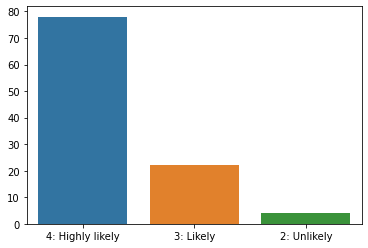

In [63]:
sns.barplot(df['comfort_with_help_from_other_gender'].value_counts().keys(),df['comfort_with_help_from_other_gender'].value_counts().values)

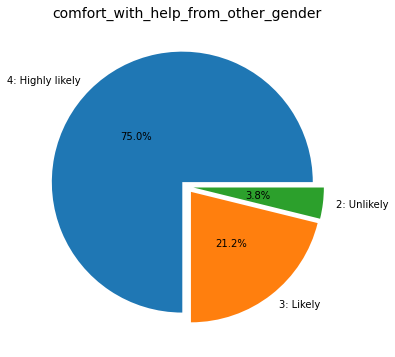

In [64]:
pie_chart('comfort_with_help_from_other_gender','comfort_with_help_from_other_gender_pie',df['comfort_with_help_from_other_gender'],3)

## project_with_other_gender
**13) How likely are you willing to work on a project with someone from the opposite gender?**

In [65]:
df['project_with_other_gender'].value_counts()

4: Highly likely      71
3: Likely             24
2: Unlikely            7
1: Highly unlikely     2
Name: project_with_other_gender, dtype: int64

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

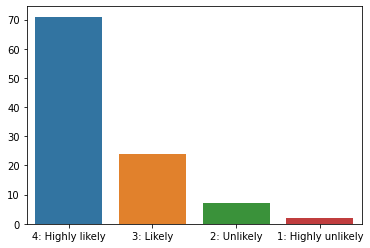

In [66]:
sns.barplot(df['project_with_other_gender'].value_counts().keys(),df['project_with_other_gender'].value_counts().values)

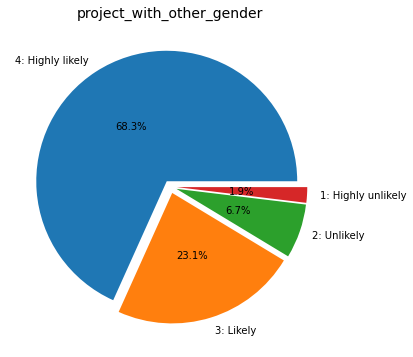

In [67]:
pie_chart('project_with_other_gender','project_with_other_gender_pie',df['project_with_other_gender'],4)

## events_that_influnced_gender_views
**14) If you studied abroad, can you identify any event that influenced your views about gender?**

In [68]:
df['events_that_influnced_gender_views'].isnull().sum()

79

In [70]:
df['events_that_influnced_gender_views'].fillna('n/a',inplace=True)
df['events_that_influnced_gender_views'].replace([' ','?','.','Ok'],'n/a',inplace=True)

In [71]:
df['events_that_influnced_gender_views'].value_counts()

n/a                                                                                                                                                                                                                                                                                                                                                                                84
Women’s day                                                                                                                                                                                                                                                                                                                                                                         1
Club members                                                                                                                                                                                                                                                

## with_or_aginst_mixed_sex_universities
**15) Are you with or against mixed-sex universities in Saudi?**

In [75]:
df['with_or_aginst_mixed_sex_universities'].isnull().sum()

0

In [76]:
df['with_or_aginst_mixed_sex_universities'].value_counts()

With mixed-sex universities       72
Against mixed-sex universities    32
Name: with_or_aginst_mixed_sex_universities, dtype: int64

<AxesSubplot:xlabel='with_or_aginst_mixed_sex_universities', ylabel='Count'>

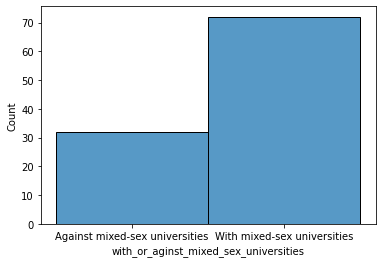

In [77]:
sns.histplot(df['with_or_aginst_mixed_sex_universities'])

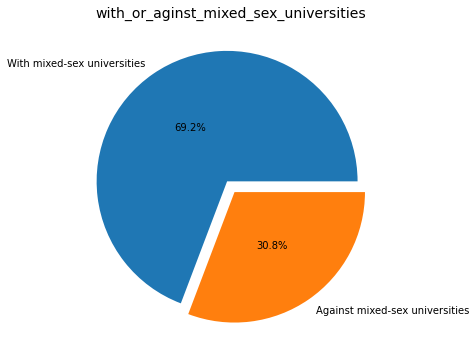

In [78]:
pie_chart('with_or_aginst_mixed_sex_universities','with_or_aginst_mixed_sex_universities_pie',df['with_or_aginst_mixed_sex_universities'],2)

## opinion_mixed_sex_universites
**16) What do you think about having mixed-sex universities in Saudi? Please list three reasons why or why not**

In [79]:
df['opinion_mixed_sex_universites'].isnull().sum()

2

In [80]:
df['opinion_mixed_sex_universites'].fillna('n/a',inplace=True)
df['opinion_mixed_sex_universites'].replace([' ','?','.','Ok'],'n/a',inplace=True)

In [81]:
df['opinion_mixed_sex_universites'].value_counts()

n/a                                                                                                                                                                                                                   5
Because everyone deserve an opportunity                                                                                                                                                                               3
- University is a comfortable place to most girls and the mixed-sex can be a uncomfortable. - It’s hard to understand each other from opposite genders sometimes that can effect the learning process                 2
1) helps both genders learn how to communicate with eachother respectively 2) enhances networking 3) both genders can learn from eachother                                                                            2
1- university student tend to be immature \n2- I’m with partially mix\n3- not applicable in very city yet                               

In [82]:
df['opinion_mixed_sex_universites'].value_counts()

n/a                                                                                                                                                                                                                   5
Because everyone deserve an opportunity                                                                                                                                                                               3
- University is a comfortable place to most girls and the mixed-sex can be a uncomfortable. - It’s hard to understand each other from opposite genders sometimes that can effect the learning process                 2
1) helps both genders learn how to communicate with eachother respectively 2) enhances networking 3) both genders can learn from eachother                                                                            2
1- university student tend to be immature \n2- I’m with partially mix\n3- not applicable in very city yet                               

In [83]:
for i in df['opinion_mixed_sex_universites']:
    print(i)

n/a
Against it, privacy, competitiveness, security
Open mind, ice breaks and  better environment
1- it’s could be a problem in our society’s culture, 2- could create problems sexually, 3- could create issues with academic performance
I agree.
1. Preparing students for mixed-sex working places
2. Learning how to become comfortable with the other sex 
3. Getting used to the boadaries between both sexes. 
1- it would help our society shed their antiquated ideas about gender roles
2- prepares a new generation for the already unsegregated work environment
3- reducing the unnecessary costs of having two campuses 
Bring diversity, get them prepared for work culture, integration 
Mixed-sex can improve the quality of education 
Less cost 
Less resources
Great idea
Great
Great
I am only against It because of one reason. It is hard to stay in hijab all day especially the face cover. 
Both genders can understand eachother more
I think it’ll be good
It helps break the barrier that many end up facin

# Feature Extraction

In [79]:
# ADD Conservitive and radical

## <font color='red'>introversion(new_feature)</font>

In [84]:
introversion = []
for i in range(0,len(df)):
    if df['introversion_personal'][i]=='Going out with friends' and df['introversion_public'][i]=='Outgoing and talkative':
        introversion.append('extrovert')
    elif df['introversion_personal'][i]=='Inner reflection and solitude' and df['introversion_public'][i]=='Quiet and reflective':
        introversion.append('introvert')
    else:
        introversion.append('introvert/extrovert')
        
    
df['introversion'] = introversion

In [85]:
df[['introversion_personal','introversion_public','introversion']].head(5)

,introversion_personal,introversion_public,introversion
0,Inner reflection and solitude,Quiet and reflective,introvert
1,Going out with friends,Outgoing and talkative,extrovert
2,Inner reflection and solitude,Outgoing and talkative,introvert/extrovert
3,Inner reflection and solitude,Outgoing and talkative,introvert/extrovert
4,Going out with friends,Outgoing and talkative,extrovert


In [86]:
df['introversion'].head()

0              introvert
1              extrovert
2    introvert/extrovert
3    introvert/extrovert
4              extrovert
Name: introversion, dtype: object

In [87]:
df[['introversion','introversion_personal','introversion_public']].head(40)

,introversion,introversion_personal,introversion_public
0,introvert,Inner reflection and solitude,Quiet and reflective
1,extrovert,Going out with friends,Outgoing and talkative
2,introvert/extrovert,Inner reflection and solitude,Outgoing and talkative
3,introvert/extrovert,Inner reflection and solitude,Outgoing and talkative
4,extrovert,Going out with friends,Outgoing and talkative
5,introvert,Inner reflection and solitude,Quiet and reflective
6,introvert/extrovert,Inner reflection and solitude,Outgoing and talkative
7,extrovert,Going out with friends,Outgoing and talkative
8,extrovert,Going out with friends,Outgoing and talkative
9,extrovert,Going out with friends,Outgoing and talkative


In [88]:
df['introversion'].value_counts()

introvert/extrovert    52
introvert              28
extrovert              24
Name: introversion, dtype: int64

<AxesSubplot:xlabel='introversion', ylabel='Count'>

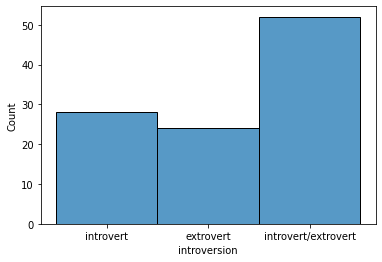

In [89]:
sns.histplot(df['introversion'])

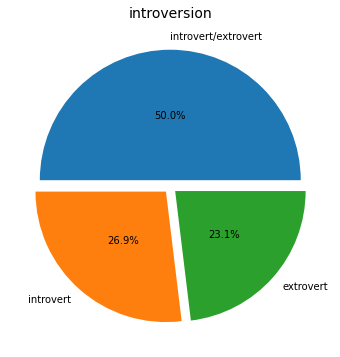

In [90]:
pie_chart('introversion','introversion_pie',df['introversion'],3)

In [91]:
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites', 'introversion'],
      dtype='object')

## <font color='red'>mixed_sex_weighted</font>

In [92]:
'''
    Weight mapper for mixed sex:
    6) Have you ever studied in a mixed-sex university?
    
    This function takes answers from question 6 and gives weights to possible inputs:
    
    Yes, undergrad == .75  
    No, neither == 0    
    Yes, grad == .5       
    Yes, both == 1

'''
def mixed_sex_mapper(data_point):
    i = data_point
    if i == 'Yes, both':
        return 1
    elif i == 'Yes, undergrad':
        return .75
    elif i == 'Yes, grad':
        return .5
    else :
        return 0

In [93]:
df['mixed_sex_weighted'] = df['mixed_sex'].apply(lambda x: mixed_sex_mapper(x))

In [94]:
df[['mixed_sex_weighted','mixed_sex']].value_counts()

mixed_sex_weighted  mixed_sex     
0.75                Yes, undergrad    52
0.00                No, neither       31
0.50                Yes, grad         10
1.00                Yes, both          9
0.00                n/a                2
dtype: int64

In [98]:
df[['mixed_sex_weighted','mixed_sex']].head(10)

,mixed_sex_weighted,mixed_sex
0,0.75,"Yes, undergrad"
1,0.50,"Yes, grad"
2,0.00,"No, neither"
3,0.00,"No, neither"
4,0.00,"No, neither"
5,0.00,"No, neither"
6,0.50,"Yes, grad"
7,0.50,"Yes, grad"
8,0.00,"No, neither"
9,0.75,"Yes, undergrad"


## <font color='red'>household_chores_num</font>

In [99]:
df['household_chores'].value_counts()

3: Agree                48
4: Strongly agree       35
2: Disagree             18
1: Strongly disagree     3
Name: household_chores, dtype: int64

In [100]:
df['household_chores_num'] = df['household_chores'].apply(lambda x : int(x.split(':')[0]))

In [101]:
df[['household_chores_num','household_chores']].value_counts()

household_chores_num  household_chores    
3                     3: Agree                48
4                     4: Strongly agree       35
2                     2: Disagree             18
1                     1: Strongly disagree     3
dtype: int64

In [102]:
df[['household_chores_num','household_chores']].head(10)

,household_chores_num,household_chores
0,4,4: Strongly agree
1,2,2: Disagree
2,4,4: Strongly agree
3,3,3: Agree
4,4,4: Strongly agree
5,4,4: Strongly agree
6,3,3: Agree
7,2,2: Disagree
8,3,3: Agree
9,3,3: Agree


## <font color='red'>comfort_with_other_gender_num</font>

In [103]:
df['comfort_with_other_gender'].value_counts()

4: Very comfortable      45
3: Comfortable           45
2: Uncomfortable         10
1: Very uncomfortable     4
Name: comfort_with_other_gender, dtype: int64

In [104]:
df['comfort_with_other_gender_num'] = df['comfort_with_other_gender'].apply(lambda x : int(x.split(':')[0]))

In [105]:
df[['comfort_with_other_gender_num','comfort_with_other_gender']].value_counts()

comfort_with_other_gender_num  comfort_with_other_gender
4                              4: Very comfortable          45
3                              3: Comfortable               45
2                              2: Uncomfortable             10
1                              1: Very uncomfortable         4
dtype: int64

In [106]:
df[['comfort_with_other_gender_num','comfort_with_other_gender']].head(10)

,comfort_with_other_gender_num,comfort_with_other_gender
0,4,4: Very comfortable
1,3,3: Comfortable
2,4,4: Very comfortable
3,3,3: Comfortable
4,3,3: Comfortable
5,4,4: Very comfortable
6,3,3: Comfortable
7,3,3: Comfortable
8,4,4: Very comfortable
9,3,3: Comfortable


## <font color='red'>comfort_with_help_from_other_gender_num</font>

In [175]:
df['comfort_with_help_from_other_gender'].value_counts()

4: Highly likely    78
3: Likely           22
2: Unlikely          4
Name: comfort_with_help_from_other_gender, dtype: int64

In [108]:
df['comfort_with_help_from_other_gender_num'] = df['comfort_with_help_from_other_gender'].apply(lambda x : int(x.split(':')[0]))

In [109]:
df[['comfort_with_help_from_other_gender_num','comfort_with_help_from_other_gender']]

,comfort_with_help_from_other_gender_num,comfort_with_help_from_other_gender
0,4,4: Highly likely
1,3,3: Likely
2,4,4: Highly likely
3,4,4: Highly likely
4,4,4: Highly likely
...,...,...
99,4,4: Highly likely
100,4,4: Highly likely
101,4,4: Highly likely
102,4,4: Highly likely


In [110]:
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites', 'introversion', 'mixed_sex_weighted',
       'household_chores_num', 'comfort_with_other_gender_num',
       'comfort_with_help_from_other_gender_num'],
      dtype='object')

## <font color='red'>project_with_other_gender_num</font>

In [176]:
df['project_with_other_gender'].value_counts()

4: Highly likely      71
3: Likely             24
2: Unlikely            7
1: Highly unlikely     2
Name: project_with_other_gender, dtype: int64

In [112]:
df['project_with_other_gender_num'] = df['project_with_other_gender'].apply(lambda x : int(x.split(':')[0]))

In [113]:
df[['project_with_other_gender_num','project_with_other_gender']]

,project_with_other_gender_num,project_with_other_gender
0,4,4: Highly likely
1,3,3: Likely
2,4,4: Highly likely
3,3,3: Likely
4,4,4: Highly likely
...,...,...
99,4,4: Highly likely
100,4,4: Highly likely
101,4,4: Highly likely
102,4,4: Highly likely


### Ideas for feature engineering

- Conservitive vs radical
- ((Find quantitative data source))

## Explatory Data Analysis

In [114]:
grouped_introversion=df[['introversion','gender','with_or_aginst_mixed_sex_universities']].groupby('introversion')
grouped_introversion.head()

,introversion,gender,with_or_aginst_mixed_sex_universities
0,introvert,Female,Against mixed-sex universities
1,extrovert,Male,Against mixed-sex universities
2,introvert/extrovert,Male,With mixed-sex universities
3,introvert/extrovert,Female,Against mixed-sex universities
4,extrovert,Female,With mixed-sex universities
5,introvert,Male,With mixed-sex universities
6,introvert/extrovert,Female,With mixed-sex universities
7,extrovert,Male,With mixed-sex universities
8,extrovert,Female,With mixed-sex universities
9,extrovert,Male,With mixed-sex universities


#### Weight/Scale
**mixed_sex_weighted**
- weight : 
           Yes, undergrad == .75  
           No, neither == 0    
           Yes, grad == .5       
           Yes, both == 1 )
         
**household_chores_num**
- scale :  
           4: Strongly agree 
           3: Agree                     
           2: Disagree             
           1: Strongly disagree

**comfort_with_other_gender**
- Scale :  
           4: Very comfortable     
           3: Comfortable           
           2: Uncomfortable         
           1: Very uncomfortable 
         
**comfort_with_help_from_other_gender_num**
- Scale :  
           4: Highly likely    
           3: Likely           
           2: Unlikely    
           1: Highly Unlikely
         
**project_with_other_gender_num**
- Scale :  
           4: Highly likely    
           3: Likely           
           2: Unlikely    
           1: Highly Unlikely
'''

In [178]:
df.groupby("gender").mean().T

gender,Female,Male
mixed_sex_weighted,0.442308,0.550000
household_chores_num,3.487179,2.876923
comfort_with_other_gender_num,2.974359,3.430769
comfort_with_help_from_other_gender_num,3.615385,3.769231
project_with_other_gender_num,3.487179,3.630769


In [179]:
df.groupby("introversion").mean().T

introversion,extrovert,introvert,introvert/extrovert
mixed_sex_weighted,0.552083,0.446429,0.524038
household_chores_num,2.666667,3.250000,3.230769
comfort_with_other_gender_num,3.333333,3.107143,3.307692
comfort_with_help_from_other_gender_num,3.791667,3.642857,3.711538
project_with_other_gender_num,3.708333,3.535714,3.538462


In [115]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

<AxesSubplot:xlabel='introversion', ylabel='gender'>

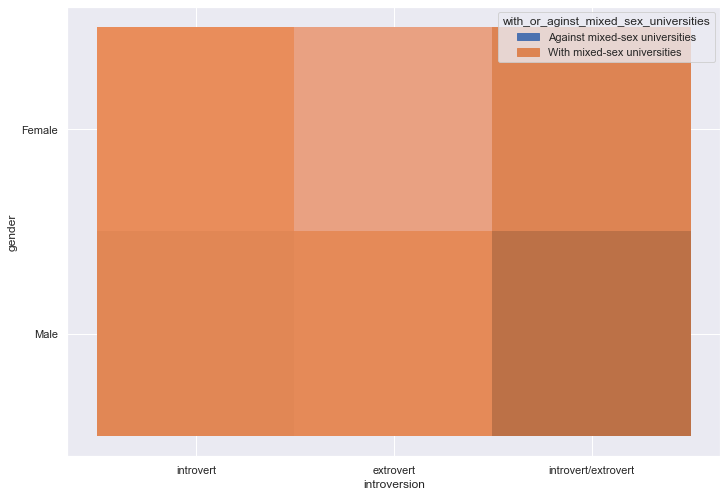

In [116]:
sns.histplot(x='introversion',y='gender',hue='with_or_aginst_mixed_sex_universities',data=df)

# Model_preparation

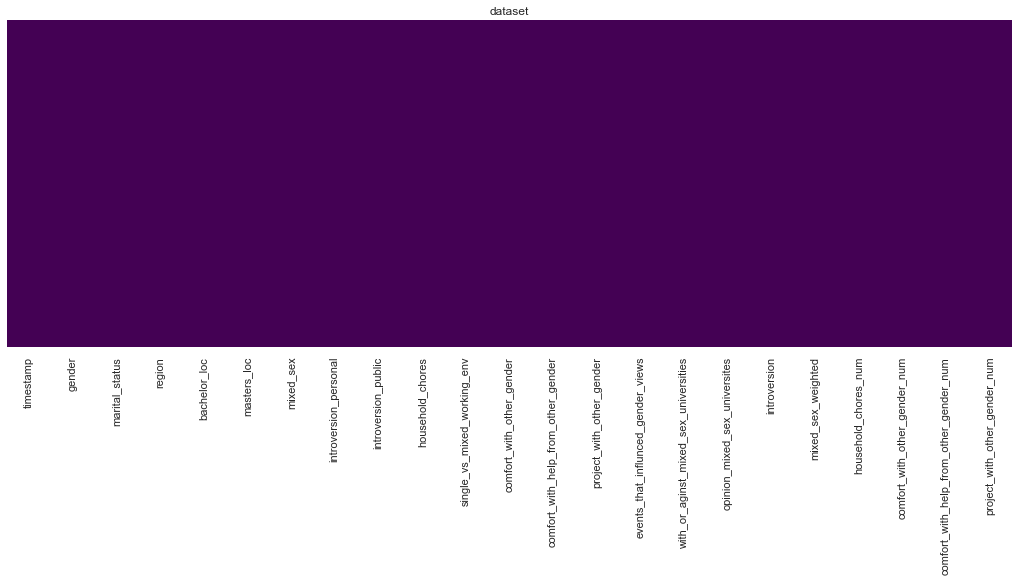

timestamp : % 0 With 0 missing values
gender : % 0 With 0 missing values
marital_status : % 0 With 0 missing values
region : % 0 With 0 missing values
bachelor_loc : % 0 With 0 missing values
masters_loc : % 0 With 0 missing values
mixed_sex : % 0 With 0 missing values
introversion_personal : % 0 With 0 missing values
introversion_public : % 0 With 0 missing values
household_chores : % 0 With 0 missing values
single_vs_mixed_working_env : % 0 With 0 missing values
comfort_with_other_gender : % 0 With 0 missing values
comfort_with_help_from_other_gender : % 0 With 0 missing values
project_with_other_gender : % 0 With 0 missing values
events_that_influnced_gender_views : % 0 With 0 missing values
with_or_aginst_mixed_sex_universities : % 0 With 0 missing values
opinion_mixed_sex_universites : % 0 With 0 missing values
introversion : % 0 With 0 missing values
mixed_sex_weighted : % 0 With 0 missing values
household_chores_num : % 0 With 0 missing values
comfort_with_other_gender_num : % 0

In [117]:
missing_heat_map(df)

In [118]:
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites', 'introversion', 'mixed_sex_weighted',
       'household_chores_num', 'comfort_with_other_gender_num',
       'comfort_with_help_from_other_gender_num',
       'project_with_other_gender_num'],
      dtype='object')

In [119]:
mod_df = df.copy()

In [120]:
mod_df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites', 'introversion', 'mixed_sex_weighted',
       'household_chores_num', 'comfort_with_other_gender_num',
       'comfort_with_help_from_other_gender_num',
       'project_with_other_gender_num'],
      dtype='object')

In [121]:
#select the features to drop because it will intoduce a huge number of features when dummied 
features = ['opinion_mixed_sex_universites','events_that_influnced_gender_views','introversion',\
            'with_or_aginst_mixed_sex_universities','timestamp',\
            
            'introversion_personal','introversion_public','household_chores','comfort_with_other_gender',\
            'comfort_with_help_from_other_gender','project_with_other_gender']
select_features = [x for x in mod_df.columns if x not in features] 
select_features 

['gender',
 'marital_status',
 'region',
 'bachelor_loc',
 'masters_loc',
 'mixed_sex',
 'single_vs_mixed_working_env',
 'mixed_sex_weighted',
 'household_chores_num',
 'comfort_with_other_gender_num',
 'comfort_with_help_from_other_gender_num',
 'project_with_other_gender_num']

In [122]:
x = mod_df[select_features] 
y = mod_df['with_or_aginst_mixed_sex_universities']
print(len(x),len(y))

104 104


In [123]:
y.head()

0    Against mixed-sex universities
1    Against mixed-sex universities
2       With mixed-sex universities
3    Against mixed-sex universities
4       With mixed-sex universities
Name: with_or_aginst_mixed_sex_universities, dtype: object

In [124]:
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites', 'introversion', 'mixed_sex_weighted',
       'household_chores_num', 'comfort_with_other_gender_num',
       'comfort_with_help_from_other_gender_num',
       'project_with_other_gender_num'],
      dtype='object')

### Dummies

In [125]:
x = pd.get_dummies(x,drop_first=True) #Converting the data into dummies to apply to models
x.head()

,mixed_sex_weighted,household_chores_num,comfort_with_other_gender_num,comfort_with_help_from_other_gender_num,project_with_other_gender_num,gender_Male,marital_status_Single,region_Eastern,region_Nothern,region_Western,bachelor_loc_Saudi,bachelor_loc_n/a,masters_loc_Saudi,masters_loc_n/a,"mixed_sex_Yes, both","mixed_sex_Yes, grad","mixed_sex_Yes, undergrad",mixed_sex_n/a,single_vs_mixed_working_env_Single-sex work environment
0,0.75,4,4,4,4,0,1,1,0,0,0,0,0,1,0,0,1,0,0
1,0.50,2,3,3,3,1,1,0,0,0,1,0,0,0,0,1,0,0,1
2,0.00,4,4,4,4,1,1,0,0,0,1,0,0,1,0,0,0,0,0
3,0.00,3,3,4,3,0,1,0,0,0,1,0,0,1,0,0,0,0,1
4,0.00,4,3,4,4,0,1,1,0,0,1,0,0,1,0,0,0,0,0


In [126]:
y = pd.get_dummies(y,drop_first=True)
y.head()

,With mixed-sex universities
0,0
1,0
2,1
3,0
4,1


In [127]:
df_corr = x.copy()

In [128]:
df_corr['With mixed-sex universities'] = y

In [129]:
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites', 'introversion', 'mixed_sex_weighted',
       'household_chores_num', 'comfort_with_other_gender_num',
       'comfort_with_help_from_other_gender_num',
       'project_with_other_gender_num'],
      dtype='object')

In [130]:
df['with_or_aginst_mixed_sex_universities'].value_counts()

With mixed-sex universities       72
Against mixed-sex universities    32
Name: with_or_aginst_mixed_sex_universities, dtype: int64

In [131]:
df_corr.columns

Index(['mixed_sex_weighted', 'household_chores_num',
       'comfort_with_other_gender_num',
       'comfort_with_help_from_other_gender_num',
       'project_with_other_gender_num', 'gender_Male', 'marital_status_Single',
       'region_Eastern', 'region_Nothern', 'region_Western',
       'bachelor_loc_Saudi', 'bachelor_loc_n/a', 'masters_loc_Saudi',
       'masters_loc_n/a', 'mixed_sex_Yes, both', 'mixed_sex_Yes, grad',
       'mixed_sex_Yes, undergrad', 'mixed_sex_n/a',
       'single_vs_mixed_working_env_Single-sex work environment',
       'With mixed-sex universities'],
      dtype='object')

In [132]:
magnify_corr(df_corr)

,mixed_sex_weighted,household_chores_num,comfort_with_other_gender_num,comfort_with_help_from_other_gender_num,project_with_other_gender_num,gender_Male,marital_status_Single,region_Eastern,region_Nothern,region_Western,bachelor_loc_Saudi,bachelor_loc_n/a,masters_loc_Saudi,masters_loc_n/a,"mixed_sex_Yes, both","mixed_sex_Yes, grad","mixed_sex_Yes, undergrad",mixed_sex_n/a,single_vs_mixed_working_env_Single-sex work environment,With mixed-sex universities
mixed_sex_weighted,1.00,0.08,0.38,0.20,0.27,0.14,-0.22,0.10,0.13,-0.02,-0.51,-0.20,-0.19,-0.04,0.42,-0.01,0.66,-0.20,-0.30,0.20
household_chores_num,0.08,1.00,-0.01,0.10,0.12,-0.38,0.03,0.08,0.11,0.01,-0.03,-0.02,0.03,0.03,0.09,-0.13,0.06,-0.02,-0.25,0.17
comfort_with_other_gender_num,0.38,-0.01,1.00,0.62,0.62,0.28,-0.08,-0.10,0.09,0.09,-0.32,0.04,-0.25,0.04,0.12,-0.07,0.31,0.04,-0.21,0.19
comfort_with_help_from_other_gender_num,0.20,0.10,0.62,1.00,0.81,0.14,0.02,0.12,0.05,0.06,-0.10,-0.06,-0.30,0.10,0.04,-0.13,0.22,-0.06,-0.32,0.30
project_with_other_gender_num,0.27,0.12,0.62,0.81,1.00,0.10,-0.03,0.13,0.06,-0.03,-0.16,-0.02,-0.38,0.19,0.04,-0.17,0.30,-0.02,-0.44,0.40
gender_Male,0.14,-0.38,0.28,0.14,0.10,1.00,0.15,0.04,0.08,0.13,-0.29,0.11,-0.10,-0.03,-0.11,-0.08,0.26,0.11,-0.11,-0.09
marital_status_Single,-0.22,0.03,-0.08,0.02,-0.03,0.15,1.00,0.10,0.02,0.14,0.07,0.03,0.06,-0.12,-0.22,0.08,-0.08,0.03,-0.07,-0.08
region_Eastern,0.10,0.08,-0.10,0.12,0.13,0.04,0.10,1.00,-0.04,-0.24,-0.21,-0.06,-0.09,-0.01,-0.03,-0.04,0.14,-0.06,-0.22,0.10
region_Nothern,0.13,0.11,0.09,0.05,0.06,0.08,0.02,-0.04,1.00,-0.06,0.07,-0.01,-0.02,0.05,0.32,-0.03,-0.10,-0.01,-0.05,0.07
region_Western,-0.02,0.01,0.09,0.06,-0.03,0.13,0.14,-0.24,-0.06,1.00,-0.13,-0.08,-0.13,0.11,-0.02,-0.11,0.04,-0.08,-0.09,-0.05


In [133]:
# get the top 10 correlated features with price
top_features = top_corr_features('With mixed-sex universities',10,df_corr)
for i in top_features:
    print(i)

list of 10 best positive features based on pairwise correlation:
 ['With mixed-sex universities', 'project_with_other_gender_num', 'comfort_with_help_from_other_gender_num', 'mixed_sex_weighted', 'comfort_with_other_gender_num', 'household_chores_num', 'mixed_sex_Yes, both', 'mixed_sex_Yes, undergrad', 'region_Eastern', 'region_Nothern']
With mixed-sex universities
project_with_other_gender_num
comfort_with_help_from_other_gender_num
mixed_sex_weighted
comfort_with_other_gender_num
household_chores_num
mixed_sex_Yes, both
mixed_sex_Yes, undergrad
region_Eastern
region_Nothern


In [134]:
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites', 'introversion', 'mixed_sex_weighted',
       'household_chores_num', 'comfort_with_other_gender_num',
       'comfort_with_help_from_other_gender_num',
       'project_with_other_gender_num'],
      dtype='object')

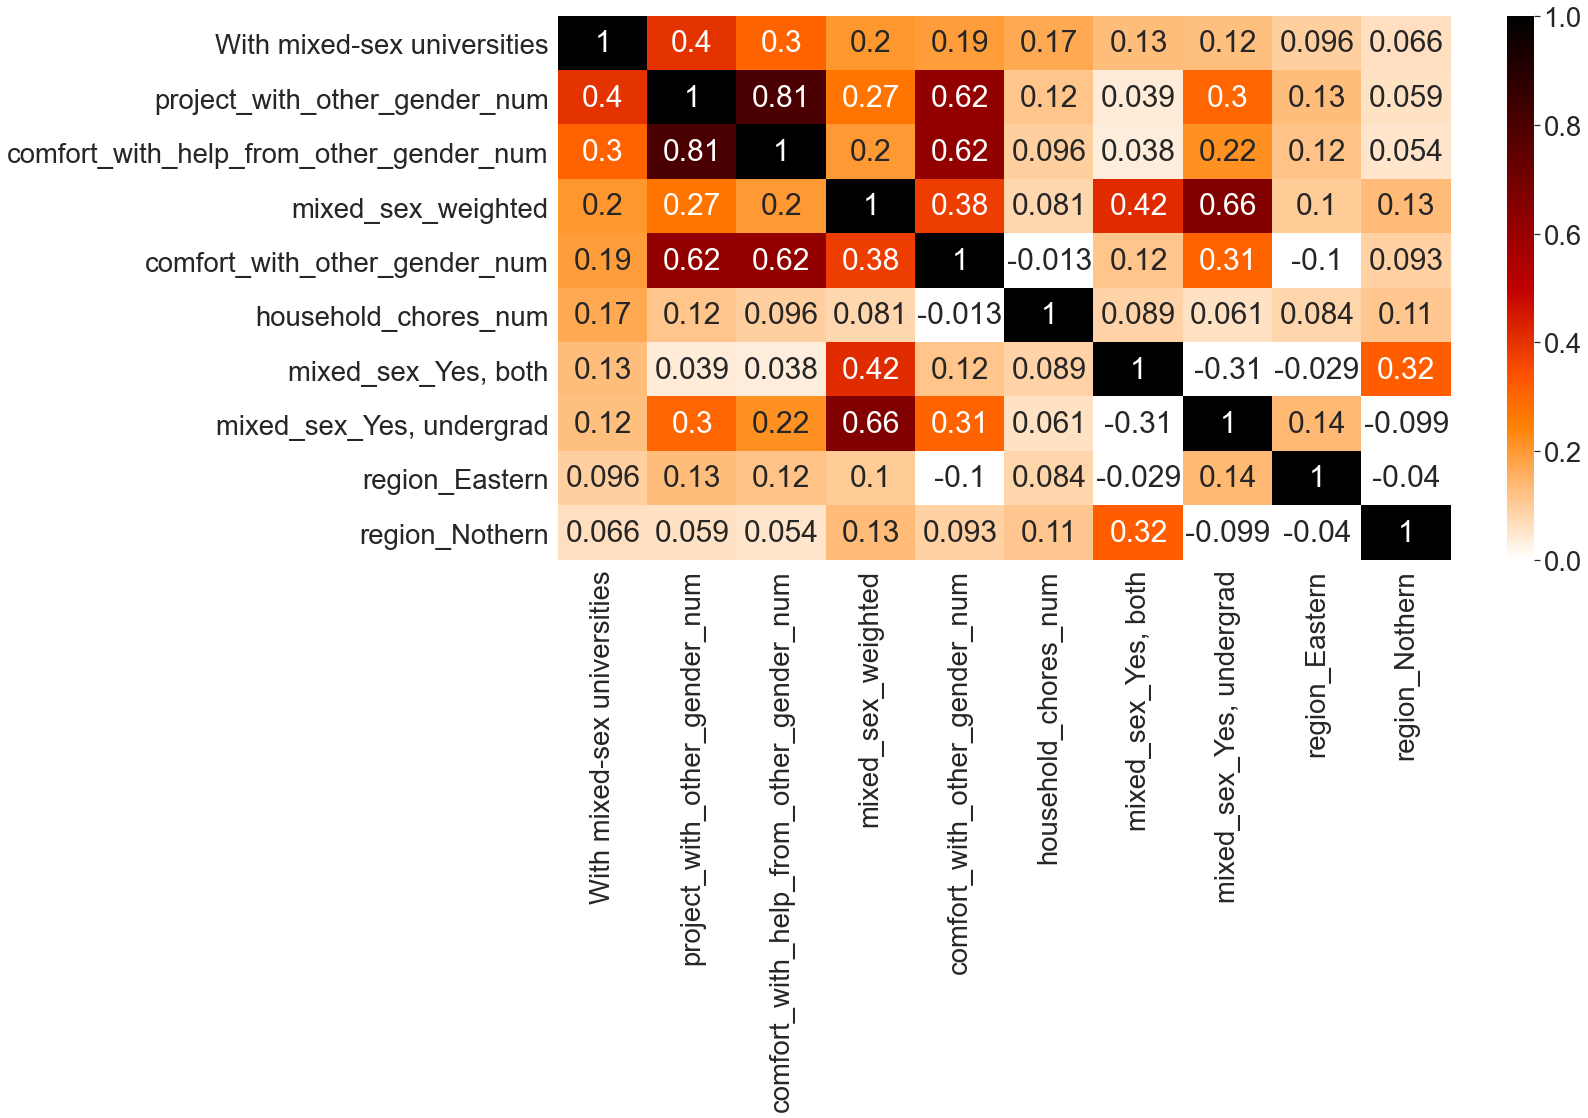

In [135]:
plot_corr(df_corr[top_features])

In [136]:
#scaled the x varible 
scaler = StandardScaler()
x_ss = scaler.fit_transform(x)

In [137]:
x.head()

,mixed_sex_weighted,household_chores_num,comfort_with_other_gender_num,comfort_with_help_from_other_gender_num,project_with_other_gender_num,gender_Male,marital_status_Single,region_Eastern,region_Nothern,region_Western,bachelor_loc_Saudi,bachelor_loc_n/a,masters_loc_Saudi,masters_loc_n/a,"mixed_sex_Yes, both","mixed_sex_Yes, grad","mixed_sex_Yes, undergrad",mixed_sex_n/a,single_vs_mixed_working_env_Single-sex work environment
0,0.75,4,4,4,4,0,1,1,0,0,0,0,0,1,0,0,1,0,0
1,0.50,2,3,3,3,1,1,0,0,0,1,0,0,0,0,1,0,0,1
2,0.00,4,4,4,4,1,1,0,0,0,1,0,0,1,0,0,0,0,0
3,0.00,3,3,4,3,0,1,0,0,0,1,0,0,1,0,0,0,0,1
4,0.00,4,3,4,4,0,1,1,0,0,1,0,0,1,0,0,0,0,0


In [138]:
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y, test_size=0.3)

In [139]:
x_train.columns

Index(['mixed_sex_weighted', 'household_chores_num',
       'comfort_with_other_gender_num',
       'comfort_with_help_from_other_gender_num',
       'project_with_other_gender_num', 'gender_Male', 'marital_status_Single',
       'region_Eastern', 'region_Nothern', 'region_Western',
       'bachelor_loc_Saudi', 'bachelor_loc_n/a', 'masters_loc_Saudi',
       'masters_loc_n/a', 'mixed_sex_Yes, both', 'mixed_sex_Yes, grad',
       'mixed_sex_Yes, undergrad', 'mixed_sex_n/a',
       'single_vs_mixed_working_env_Single-sex work environment'],
      dtype='object')

# Modeling

In [141]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
print('Logreg predicted probabilities for x_test:\n', logreg.predict_proba(x_test))

Logreg predicted probabilities for x_test:
 [[0.2846531  0.7153469 ]
 [0.16398507 0.83601493]
 [0.6462554  0.3537446 ]
 [0.2846531  0.7153469 ]
 [0.15688751 0.84311249]
 [0.31228627 0.68771373]
 [0.18331249 0.81668751]
 [0.15516161 0.84483839]
 [0.71705968 0.28294032]
 [0.11691424 0.88308576]
 [0.31228627 0.68771373]
 [0.20968351 0.79031649]
 [0.1093248  0.8906752 ]
 [0.19013664 0.80986336]
 [0.15363717 0.84636283]
 [0.07255049 0.92744951]
 [0.12341656 0.87658344]
 [0.20751976 0.79248024]
 [0.73983657 0.26016343]
 [0.17548964 0.82451036]
 [0.19437624 0.80562376]
 [0.29894086 0.70105914]
 [0.15981346 0.84018654]
 [0.32821196 0.67178804]
 [0.18331249 0.81668751]
 [0.60310901 0.39689099]
 [0.2370176  0.7629824 ]
 [0.24249289 0.75750711]
 [0.08202657 0.91797343]
 [0.11691424 0.88308576]
 [0.18521624 0.81478376]
 [0.2370176  0.7629824 ]]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [158]:
train_predicted = logreg.predict(x_train)
test_predicted = logreg.predict(x_test)
print('Logreg predicted labels:\n',predicted)

Logreg predicted labels:
 [1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1]


In [159]:
y_test.head(40)

,With mixed-sex universities
13,1
41,1
3,0
58,1
37,1
103,0
102,1
55,1
68,0
65,1


In [144]:
cross_val_score(logreg,x_train,y_train,cv=5).mean()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A colu

0.8209523809523809

In [145]:
cross_val_score(logreg,x_test,y_test,cv=5).mean()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A colu

0.8380952380952381

- True Positive (TP): Outcome where the model correctly predicts the positive class.
- True Negative (TN): Outcome where the model correctly predicts the negative class.
- False Positive (FP): Also called a type 1 error, an outcome where the model incorrectly predicts the positive class when it is actually negative.
- False Negative (FN): Also called a type 2 error, an outcome where the model incorrectly predicts the negative class when it is actually positive.

In [168]:
# Training confusion matrix
print(len(train_predicted))
tn, fp, fn, tp = confusion_matrix(y_train, train_predicted).ravel()
('TrueNegitive : {}'.format(tn), 'FalsePositive : {}'.format(fp), 'FalseNegitive : {}'.format(fn), 'TruePositive : {}'.format(tp))


72


('TrueNegitive : 15',
 'FalsePositive : 7',
 'FalseNegitive : 2',
 'TruePositive : 48')

In [173]:
print('accuracy : {}'.format(accuracy_score(y_train, train_predicted)))
# Recall
print('recall : {}'.format(recall_score(y_train, train_predicted)))
# Precision
print('precision : {}'.format(precision_score(y_train, train_predicted)))

accuracy : 0.875
recall : 0.96
precision : 0.8727272727272727


In [162]:
# Testing confustion matrix 
print(len(test_predicted))
tn, fp, fn, tp = confusion_matrix(y_test, test_predicted).ravel()
('TrueNegitive : {}'.format(tn), 'FalsePositive : {}'.format(fp), 'FalseNegitive : {}'.format(fn), 'TruePositive : {}'.format(tp))

32


('TrueNegitive : 4',
 'FalsePositive : 6',
 'FalseNegitive : 0',
 'TruePositive : 22')

In [172]:
print('accuracy : {}'.format(accuracy_score(y_test, test_predicted)))
# Recall
print('recall : {}'.format(recall_score(y_test, test_predicted)))
# Precision
print('precision : {}'.format(precision_score(y_test, test_predicted)))

accuracy : 0.8125
recall : 1.0
precision : 0.7857142857142857
